# Try SSLEM
Running the SSLEM example script from pyechomask with my own data.

In [25]:
## import packages
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyechoplot.plotting import plot_Sv, plot_mask, save_png_plot, setup_ek500_cmap

## import pyechomask modules
from pyechomask.masks import binary_seabed, binary_signal
from pyechomask.manipulate import  signal_row_filter, signal_column_filter, flag,\
        vertical_merge,feature_median, fill_feature_gaps, break_mask, remove_features

%matplotlib inline

In [26]:
## Bug fix for missing colourmap
def plot_mask_fix(mask):
    '''
    plot mask (any - binary/flag/continuous)
    '''
    ## shape
    row,col = mask.shape
    
    ## plot
    #f, (ax1) = plt.subplots(1, figsize = (20,10))
    p1       = plt.imshow(mask, cmap = plt.cm.nipy_spectral,\
            interpolation='nearest',aspect='auto')
    plt.colorbar(p1,pad = 0)
    plt.xlabel('columns',fontsize = 18)
    plt.ylabel('rows',fontsize = 18)

In [27]:
def plot_SSLEM(Sv,mask = None, sample_int=0.5):
    '''
    :param Sv: gridded Sv values (dB re 1m^-1)
    :type  Sv: 2D numpy.array
    
    :param mask: binary mask (0 - noise; 1 - signal)
    :type  mask: 2D numpy.array
    
    return:
    
    desc: Plot Sv grid, with/without binary mask
    
    defined by RP
    
    status: dev
    
    '''
    ## get echoview colormap
    setup_ek500_cmap()
    ek500_cmap = mpl.cm.get_cmap('ek500')
    ek500_norm = mpl.colors.BoundaryNorm(np.linspace(-89,-34,12), 12, clip=False)
    
    ## add mask
    if mask is not None:
        Sv = np.ma.masked_where(mask == 0,Sv)
    ## shape
    row,col = Sv.shape
    
    ## plot
    #f, (ax1) = plt.subplots(1, figsize = (20,10))
    p1       = plt.imshow(Sv, cmap = ek500_cmap,norm = ek500_norm,\
            interpolation='nearest',aspect='auto',extent=[0,col,row*sample_int,0])
    
    plt.colorbar(p1,pad = 0)
    plt.xlabel('Ping Number',fontsize = 18)
    plt.ylabel('Depth',fontsize = 18)

## SSLEM Parameters

In [28]:
## Sv observation parameters
noise_level   = -999   # background noise level (dB re 1m^-1)
sample_int    = 0.5    # sample interval (m)
pl            = 1.024 # pulse length (ms)
fq            = 333   # Frequency

## SSLEM optimization parameters (recomended setting for regional analysis)
min_sep       = 20     # minimum SSL seperation (m):min = pulse length
max_thickness = 70    # Maximun SSL thickness  (m)
min_size      = 10     # Minimun thickness of SSL (pings)
min_thickness = 10     # Minimun thickness of SSL (m)

## thresholds 
minSv = -85
maxSv = -40

In [29]:
## Sv observation parameters -- Boat files
noise_level_boat   = -999   # background noise level (dB re 1m^-1)
sample_int_boat    = 0.5    # sample interval (m)
pl_boat            = 1.024 # pulse length (ms)
fq_boat            = 38   # Frequency

## SSLEM optimization parameters (recomended setting for regional analysis)
min_sep_boat       = 50     # minimum SSL seperation (m):min = pulse length
max_thickness_boat = 100    # Maximun SSL thickness  (m)
min_size_boat      = 10    # Minimum duration of SSL (pings)
min_thickness_boat = 5     # Minimun thickness of SSL (m)

## thresholds 
minSv_boat = -90
maxSv_boat = -40

In [35]:
def SSLEM_EVfile(filename, 
                 sample_int=1, 
                 pl=1.024, 
                 fq=333, 
                 min_sep=15, 
                 min_size=15, 
                 min_thickness=5, 
                 max_thickness=70, 
                 minSv=-90, 
                 maxSv=-50):
    '''
    Apply SSL evaluation model to an Echoview cell export .xlsx file.
    
    ## Sv observation parameters
    noise_level   = -999   # background noise level (dB re 1m^-1)
    sample_int    = 0.5    # sample interval (m)
    pl            = 1.024 # pulse length (ms)
    fq            = 333   # Frequency

    ## SSLEM optimization parameters (recomended setting for regional analysis)
    min_sep       = 10     # minimum SSL seperation (m):min = pulse length
    max_thickness = 70    # Maximun SSL thickness  (m)
    min_size      = 25    # Minimum duration of SSL (pings)
    min_thickness = 10     # Minimun thickness of SSL (m)
    
    ## thresholds 
    minSv_boat = -90
    maxSv_boat = -40 
    '''
    
    
    # Open excel file into dataframe
    Sv_df = pd.read_excel(filename, header=0)

    ## Put the mean Sv data into a table, with x axis as pings and y axis as layer depth min (for now)
    Sv_table = Sv_df.pivot(index='Layer_depth_min', columns='Ping_S', values='Sv_mean')

    # Convert dataframe to numpy array to comply with the algorithm
    Sv = np.array(Sv_table)

    ## calculate number of rows/samples from meters
    min_thickness_rows = int(min_thickness/sample_int)
    min_sep_rows       = int(min_sep/sample_int)

    
    #---------------------------------
    ## SSLEM
    ## remove pulse (by pulse does he mean surface? They removed first 100m...)
    Sv[0:2,:] = noise_level  

    ## remove weak signal
    Sv[Sv < minSv] = noise_level


    ## get seabed mask, window_size refers to a rolling median filter
    ## seabed mask in development - check
    #seabed_mask, seabed_idx = binary_seabed(Sv, buffer = min_sep_rows, window_size = 10) # No seabed here.

    
    
    #-------------------------------------
    ## Identify signal pixels
    ## this step is the bottle neck
    signal_mask = binary_signal(Sv,pl,sample_int,min_sep,max_thickness,max_steps = 10)

    ## row smooth signal mask:
    ## where majority (threshold = 0.5) pixels are signal make all signal, otherwise label all noise
    signal = signal_row_filter(signal_mask,min_size,threshold = 0.5) 

    ## remove SSLs that are too thin
    signal = signal_column_filter(signal,min_thickness_rows,threshold = 1)


    ## label SSls (flag) and remove small SSLs (size < min_size*min_thickness_rows)
    signal = flag(signal,min_size*min_thickness_rows)

    ## merge SSLs that are closer together than the min seperation
    signal[signal > 0] = 1
    signal             = vertical_merge(signal,min_sep_rows)

    ## fill internal gaps - max size = min_size*min_thickness_rows
    signal = fill_feature_gaps(signal,min_size*min_thickness_rows)

    ## break merged SSLs into individual SSLs
    signal = break_mask(signal)

    ## remove small SSLs
    signal = remove_features(signal.astype(int),min_size*min_thickness_rows)

    ## get median values of each SSL
    Sv_median = feature_median(Sv,signal)

    
    
    #--------------------------------------
    ## plot results
    plt.figure(figsize=(15,10))
    plt.subplot(311)
    plot_Sv(Sv)
    plt.ylim([200,0])
    plt.title('333kHz echogram SSLEM: echogram, SSL mask and SSL median')
    plt.subplot(312)
    plot_mask_fix(signal) 
    plt.ylim([200,0])
    plt.subplot(313)
    plot_SSLEM(Sv_median) 
    plt.ylim([200,0])
    plt.show()
    return 

D:/GLIDER2018/Echosounder/EVexport\boat_20180621PM.xlsx


C:\Users\mbd\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


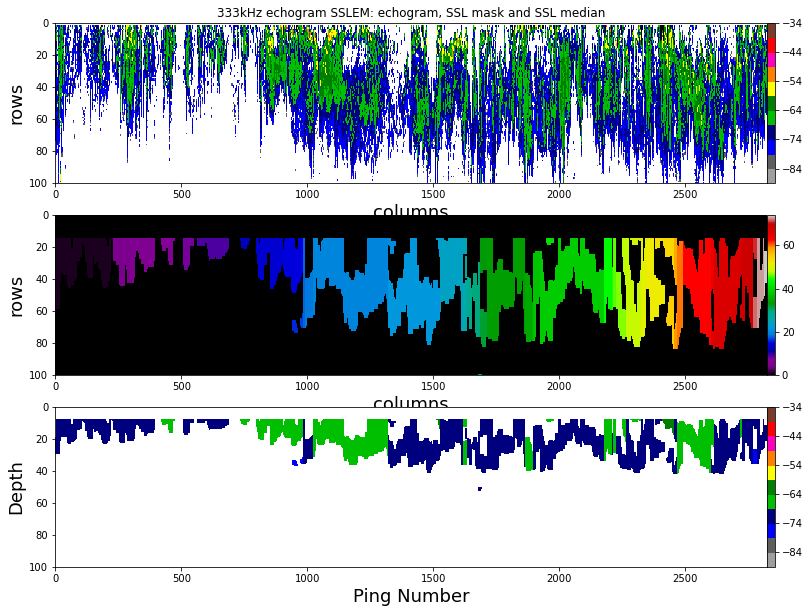

D:/GLIDER2018/Echosounder/EVexport\boat_20180622PM.xlsx


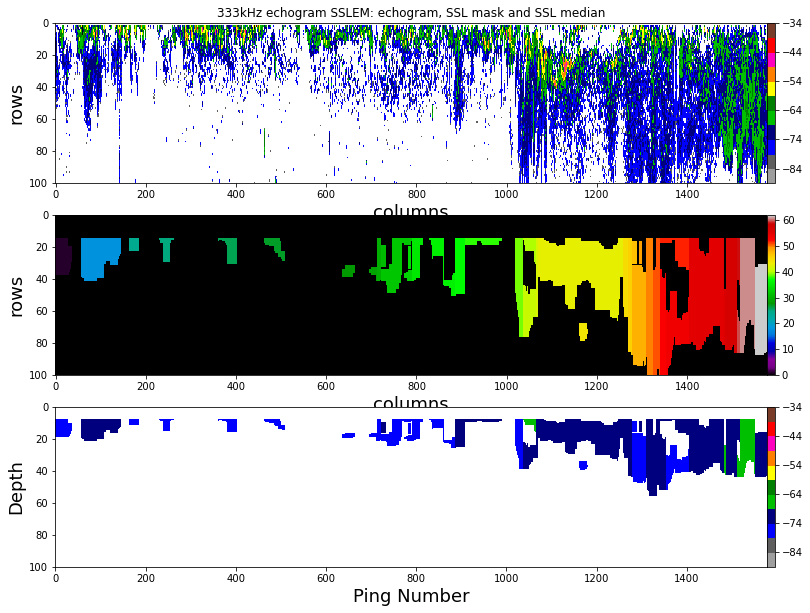

D:/GLIDER2018/Echosounder/EVexport\boat_20180624.xlsx


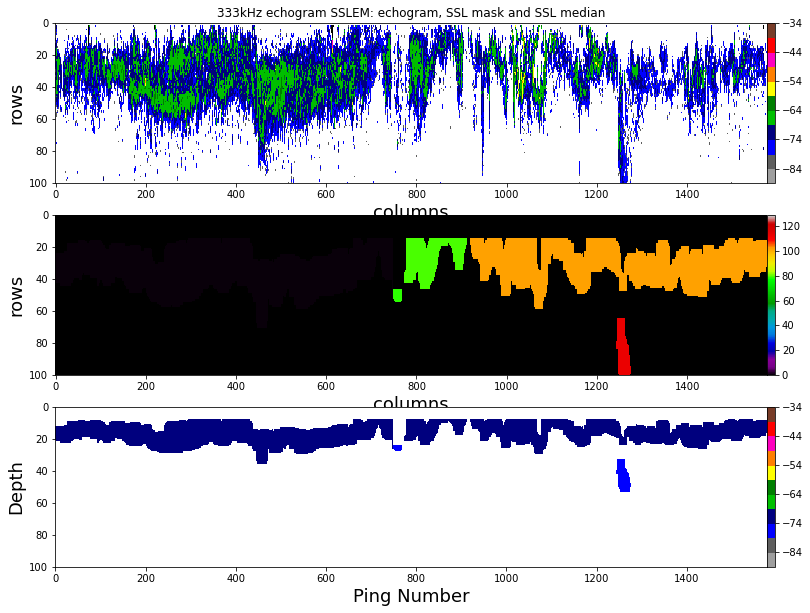

D:/GLIDER2018/Echosounder/EVexport\boat_20180625PM.xlsx


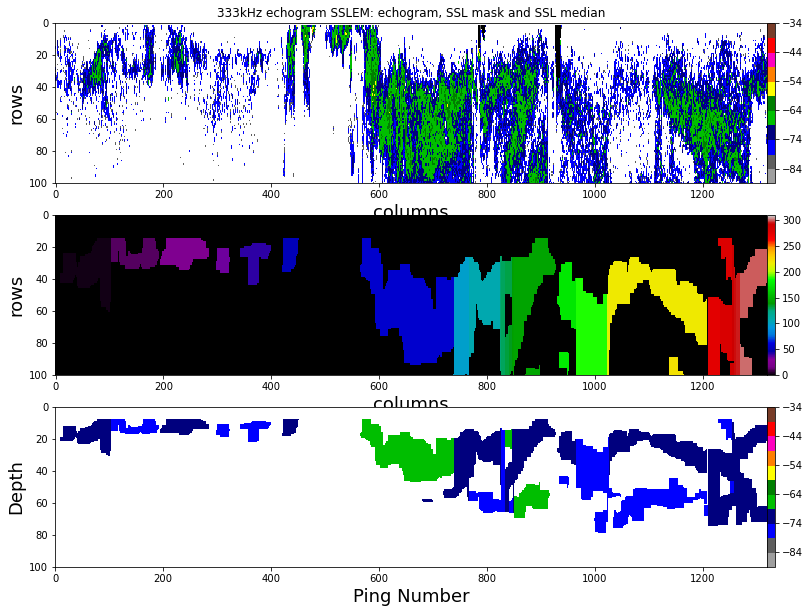

In [36]:
fname = glob.glob('D:/GLIDER2018/Echosounder/EVexport/boat_*.xlsx')
for ind in np.arange(len(fname)):
    filename = fname[ind]
    print(filename)
    SSLEM_EVfile(filename, fq=38, minSv=-80)#, sample_int=sample_int_boat, pl=pl_boat, fq=fq_boat, min_sep=min_sep_boat, min_size=min_size_boat, min_thicknes=min_thickness_boat, max_thickness=max_thickness_boat, minSv=minSv_boat, maxSv=maxSv_boat)

In [34]:
fname = glob.glob('D:/GLIDER2018/Echosounder/EVexport/SBanalysis_*.xlsx')
for ind in np.arange(len(fname)):
    filename = fname[ind]
    print(filename)
    SSLEM_EVfile(filename)